# STAT0009: STOCHASTIC SYSTEMS

### ICA 2 - GROUP 18


### **Topic**: Parameter Inference with MCMC in Heston’s Model

### Implementation Overview

This code adaptation is inspired by the calibration method for the Heston model described by Cape et al. in the paper titled "Estimating Heston's and Bates’ models parameters using Markov chain Monte Carlo simulation". Our objectives are threefold:

1. **Paper to Code Analysis**: Examine how the implementation aligns with the methodologies and algorithms proposed in the research paper.

2. **Structure Simplification**: Convert the code from an object-oriented framework to a straightforward procedural structure. This modification aims to enhance understandability for Statistical Science students at UCL.

3. **Application and Analysis**: Apply the Markov Chain Monte Carlo (MCMC) inference technique for the Heston model on a dataset comprising Google (GOOG) stock prices. This dataset differs from the S&P 500 dataset used in the original study. The goal is to analyse the performance and applicability of the model to different financial instruments.

### Install packages for statistical, mathematical and plotting utilities

In [1]:
# Uncomment to install needed packages
# !pip install numpy pandas matplotlib seaborn scipy tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from scipy.stats import truncnorm, invgamma, norm
from tqdm import tqdm # This is for visualisation
import time

### Helper Functions

In [3]:
"""
This method calculates epsilon_s in section 4.2.
"""
def eps_s(V, Y, mu, dt):
    return (Y - mu * dt + 0.5 * V[:-2] * dt) / np.sqrt(V[:-2] * dt)


"""
This method calculates epsilon_v in section 4.2.
"""
def eps_v(V, dt, kappa, theta):
    return (V[1:-1] - kappa * theta * dt - (1 - kappa * dt) * V[:-2]) / np.sqrt(V[:-2] * dt)

In this section, we start defining the parameters for the posterior distributions.
Each function is caluculating one parameter and the equations can be found in section 4.3.


In [4]:
"""
This method calculates the posterior mean of the drift parameter mu.
"""
def mu_star(psi, w, kappa, theta, V, Y, dt, mu_p, sigma2_mu_p):
    num = sum((w + psi ** 2) * (Y + 0.5 * V[:-2] * dt) / (w * V[:-2])) - \
          sum(psi * (V[1:-1] - kappa * theta * dt - (1 - kappa * dt) * V[:-2]) / (w * V[:-2])) + mu_p / sigma2_mu_p
    den = dt * sum((w + psi ** 2) / (w * V[:-2])) + 1 / sigma2_mu_p
    res = num / den
    return res


"""
This method calculates the posterior variance of the drift parameter mu.
"""
def sigma2_star(psi, w, V, dt, sigma_p):
    num = 1
    den = dt * sum((w + psi ** 2) / (w * V[:-2])) + 1 / (sigma_p ** 2)
    res = num / den
    return res


"""
This method calculates the posterior beta parameter for the inverse gamma distribution that Omega follows.
Remember that Omega is a function of the variance of volatility and
the correlation of the stock price and volatility process.
"""
def beta_star(V, Y, mu, dt, kappa, theta, beta_p, p_p, psi_p):
    epsS = eps_s(V, Y, mu, dt)
    epsV = eps_v(V, dt, kappa, theta)
    res = beta_p + 0.5 * sum(epsV ** 2) + 0.5 * p_p * psi_p ** 2 - \
          0.5 * ((p_p * psi_p + sum(epsS * epsV)) ** 2 / (p_p + sum(epsS ** 2)))
    return res


"""        
This method calculates the posterior mean parameter for the normal distribution that psi|Omega follows.
Remember that psi is a function of the standard deviation of volatility and
the correlation of the stock price and volatility process.
"""
def psi_star(Y, V, mu, dt, kappa, theta, p_p, psi_p):
    epsS = eps_s(V, Y, mu, dt)
    epsV = eps_v(V, dt, kappa, theta)
    res = (p_p * psi_p + sum(epsS * epsV)) / (p_p + sum(epsS ** 2))
    return res


"""
This method calculates the posterior variance parameter for the normal distribution that psi|Omega follows.
Remember that psi is a function of the standard deviation of volatility and
the correlation of the stock price and volatility process.
"""
def sigma2_psi_star(Y, V, mu, dt, p_p, w):
    epsS = eps_s(V, Y, mu, dt)
    res = w / (p_p + sum(epsS ** 2))
    return res


"""
This method calculates the posterior mean parameter for the normal distribution that the long term mean of volatility
theta follows.
"""
def theta_star(Y, V, mu, dt, psi, kappa, w, theta_p, sigma2_theta_p):
    num = sum(kappa * (V[1:-1] - (1 - kappa * dt) * V[:-2]) / (w * V[:-2])) - \
          sum(psi * (Y - mu * dt + 0.5 * V[:-2] * dt) * kappa / (w * V[:-2]) + theta_p / sigma2_theta_p)
    den = dt * sum(kappa ** 2 / (w * V[:-2])) + 1 / sigma2_theta_p
    res = num / den
    return res


"""
This method calculates the posterior variance parameter for the normal distribution that the long term mean of volatility
theta follows.
"""
def sigma2_theta_star(V, dt, kappa, w, sigma2_theta_p):
    den = dt * sum(kappa ** 2 / (w * V[:-2])) + 1 / sigma2_theta_p
    res = 1 / den
    return res


"""
This method calculates the posterior mean parameter for the normal distribution that the mean reversion speed coefficient
kappa follows.
"""
def kappa_star(Y, V, mu, dt, psi, theta, w, kappa_p, sigma2_kappa_p):
    num = sum((theta - V[1:-1]) * (V[1:-1] - V[:-2]) / (w * V[:-2])) - \
          sum(psi * (Y - mu * dt + 0.5 * V[:-2] * dt) * (theta - V[:-2]) / (w * V[:-2])) + kappa_p / sigma2_kappa_p
    den = dt * sum((V[:-2] - theta) ** 2 / (w * V[:-2])) + 1 / sigma2_kappa_p
    res = num / den
    return res


"""
This method calculates the posterior variance parameter for the normal distribution that the mean reversion speed coefficient
kappa follows.
"""
def sigma2_kappa_star(V, dt, theta, w, sigma2_kappa_p):
    den = dt * sum((V[:-2] - theta) ** 2 / (w * V[:-2])) + 1 / sigma2_kappa_p
    res = 1 / den
    return res



"""
In this section, we start defining the posterior distribution used in the Metropolis-Hastings sampling of V_t. 
The full likelihood function, and is very big - as such, it is broken down term-wise to improve the readability of the code.
Notice that while we have only definedone posterior distribution in the paper for V_t, we have defined three posterior distributions for our code - 
for time step t = 0, 1 <= t <= T, and t = T + 1. This is because for t = 0, terms 4 and 5 of the posterior distribution
vanish, while for t = T + 1, terms 1, 2, and 3 of the posterior distribution vanish! For 1 <= t <= T, all five terms
are present.
"""

"""
This method calculates the posterior distribution of V_t for t = 0.
"""
def ss_td_t_0(V, Y1, V1, dt, mu, w, psi, kappa, theta):
    mult = 1 / (V * dt)
    t1 =  (-1 / (2 * w)) * (((w + psi ** 2) * (0.5 * V * dt + Y1 - mu * dt) ** 2) / (V * dt))
    t2 = (-1 / (2 * w)) * ((-2 * psi * (0.5 * V * dt + Y1 - mu * dt) * ((kappa * dt - 1) * V - kappa * theta * dt + V1)) / (V * dt))
    t3 = (-1 / (2 * w)) * (((kappa * dt - 1) * V - kappa * theta * dt + V1) ** 2 / (V * dt))
    return mult * np.exp(t1 + t2 + t3)

"""
This method calculates the posterior distribution of V_t for 1 <= t <= T.
"""
def ss_td_t_1_T(V, Y, Y1, V1, Vm1, dt, mu, w, psi, kappa, theta):
    mult = 1 / (V * dt)
    t1 =  (-1 / (2 * w)) * (((w + psi ** 2) * (0.5 * V * dt + Y1 - mu * dt) ** 2) / (V * dt))
    t2 = (-1 / (2 * w)) * ((-2 * psi * (0.5 * V * dt + Y1 - mu * dt) * ((kappa * dt - 1) * V - kappa * theta * dt + V1)) / (V * dt))
    t3 = (-1 / (2 * w)) * (((kappa * dt - 1) * V - kappa * theta * dt + V1) ** 2 / (V * dt))
    t4 = (-1 / (2 * w)) * (-2 * psi * (Y - mu * dt + 0.5 * Vm1 * dt) * (V - kappa * theta * dt - (1 - kappa * dt) * Vm1) / (Vm1 * dt))
    t5 = (-1 / (2 * w)) * ((V - kappa * theta * dt - (1 - kappa * dt) * Vm1) ** 2 / (Vm1 * dt))
    return mult * np.exp(t1 + t2 + t3 + t4 + t5)

"""
This method calculates the posterior distribution of V_t for t = T + 1.
"""
def ss_td_t_Tp1(V, Y, Vm1, dt, mu, w, psi, kappa, theta):
    mult = 1 / (V * dt)
    t4 = (-1 / (2 * w)) * (-2 * psi * (Y - mu * dt + 0.5 * Vm1 * dt) * (V - kappa * theta * dt - (1 - kappa * dt) * Vm1) / (Vm1 * dt))
    t5 = (-1 / (2 * w)) * ((V - kappa * theta * dt - (1 - kappa * dt) * Vm1) ** 2 / (Vm1 * dt))
    return mult * np.exp(t4 + t5)


### Dataset Overview

Data of Google (stock ticker: GOOG) stock price was collected daily from 2021-02-23 to 2024-02-22 over the span of roughly three years. In total, there are 755 observations in total, with no empty entries. The dataset consists of 7 covariates corresponding to each column:

 - Date: The date of the trading session.
 - Open: The opening price of the stock for the day.
 - High: The highest price of the stock during the day.
 - Low: The lowest price of the stock during the day.
 - Close: The closing price of the stock for the day.
 - Adj Close: The adjusted closing price of the stock for the day, accounting for any corporate actions.
 - Volume: The total volume of stock units traded during the day.

 We start by analyse the price and volatility path of the GOOG over the three year period.

In [5]:
goog_data = pd.read_csv("GOOG.csv")
price_series = goog_data["Adj Close"].values

In [6]:
goog_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-23,101.250504,104.100502,100.100998,103.542999,103.542999,33348000
1,2021-02-24,102.091499,105.039001,101.906502,104.758499,104.758499,24966000
2,2021-02-25,103.372498,104.744003,101.064499,101.568001,101.568001,36568000
3,2021-02-26,102.526001,103.550499,100.803001,101.843002,101.843002,41670000
4,2021-03-01,102.825996,104.325996,102.305000,104.075500,104.075500,28090000


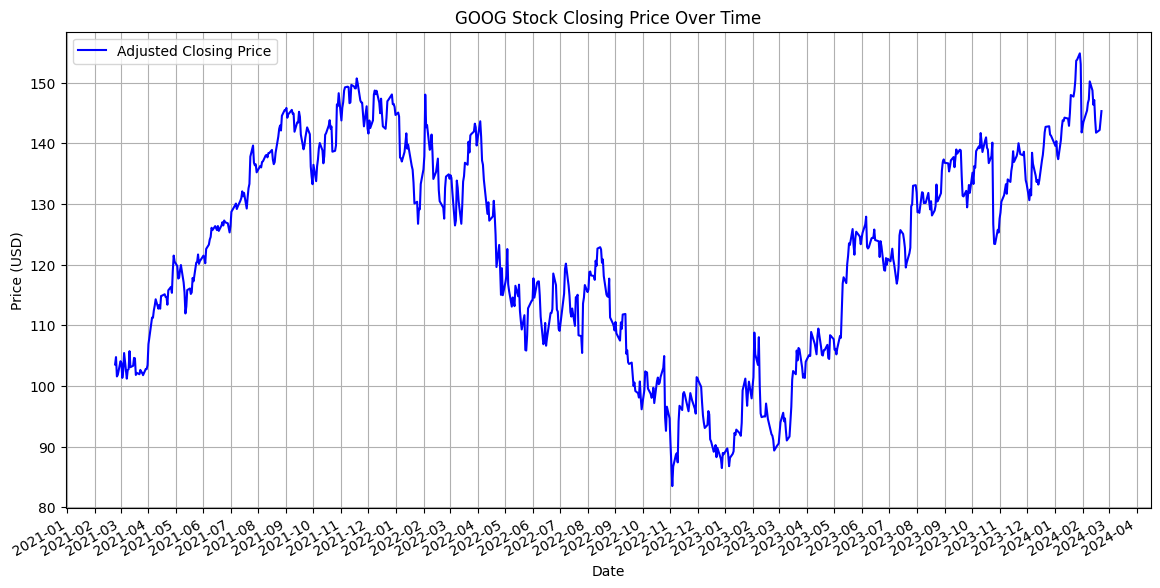

In [7]:
goog_data['Date'] = pd.to_datetime(goog_data['Date'])
plt.figure(figsize=(14, 7))
plt.plot(goog_data['Date'], goog_data['Adj Close'], label='Adjusted Closing Price', color='blue')
plt.title('GOOG Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate() 
plt.legend()
plt.grid(True)
plt.show()

The Heston model is particularly appropriate for modeling GOOG stock, as evidenced by the plots showing the stock's closing price and its 30-day rolling volatility. These plots reveal a non-constant volatility pattern, characterized by frequent and significant shifts over time, aligning well with the Heston model's assumption of stochastic volatility. This model captures the observed tendency of volatility to fluctuate randomly around a long-term mean, which is more realistic for the evident volatility spikes and the complex price movements of GOOG stock.

### Heston's Model and Calibration

In [8]:
def calibrate(n_mcmc_steps=10000, burn_in=5000, rejection_rate=0.005):

    """
    These are the initialisation of prior parameters!
    """

    # --- baseline model parameters
    returns = np.diff(np.log(price_series))
    initial_price = price_series[0]
    num_returns = len(returns)
    time_step = 1.0

    # --- initialise prior distribution parameters
    mean_prior = 0.0  # μ
    variance_prior = 1.0  # μ

    kappa_prior_mean = 0.0  # κ
    kappa_prior_variance = 1.0  # κ

    theta_prior_mean = 0.0  # θ
    theta_prior_variance = 1.0  # θ

    psi_prior_mean = 0.0  # ψ
    p_prior_value = 2.0  # ψ

    # Inverse-Gamma prior
    alpha_prior = 2.0  # Ω
    beta_prior = 0.05  


    # --- initialise posterior sample, the values of this does not affect calibration, just for plotting purposes
    mu_estimate = 0.1
    kappa_estimate = 0.2
    theta_estimate = 0.2
    omega_estimate = 1/200
    psi_estimate = 0.1

    # --- storage array for parameters
    params_array_full = None
    params_array_post_burnin = None
    params_summary_dict = None
    omega_alpha_param = num_returns / 2 + alpha_prior  # Derived parameter for Ω

    """
    We generate the initial array of asset price volatilities using a truncated normal distribution. 
    We choose a truncated normal for a few reasons:
    
    Non-Negativity: Volatility, by definition, cannot be negative. 

    Empirical Fit: While volatility isn't strictly normally distributed, 
    a truncated normal can often provide a reasonable approximation to its distribution,
    especially over short time intervals.

    Mean Reversion: Often, volatility in financial models exhibits mean-reversion. 
    A truncated normal, by limiting extreme values on either side, 
    can indirectly contribute to a mean-reverting behavior in your simulations.
    """


    """
    We also generated asset price volatility arrays that are shifted one time step backwards and forward respectively.
    This makes working with time index easier: we only need to loop through index t and obtain 3 different values of
    V at the same time.
    """

    variance_array_current = np.array(truncnorm.rvs(a=0, b=np.inf, loc=0.0225, scale=0.005, size=num_returns + 2))
    variance_array_previous = np.roll(variance_array_current, 1)
    variance_array_previous[0] = 0
    variance_array_next = np.roll(variance_array_current, -1)
    variance_array_next[-1] = 0

    """
    We do the same for the return paths. Note that we have input and output price paths into our model but the modelling process
    uses log returns, which is included in our utility functions
    """    
    returns_padded = np.append(0, np.append(returns, 0))
    returns_next_padded = np.roll(returns_padded, -1)
    returns_next_padded[-1] = 0

    """
    Now, we generate the parameter array. We simulate and store the accepted parameter values in a matrix, described in the paper.
    The columns are the volatility path and the 5 parameters, the rows are the iterations over updates.
    For example if we have N volatility values and 1,000 iterations, this storage matrix will be (1000, N+5)
    """
    params_array_full = np.zeros((n_mcmc_steps, len(variance_array_current) + 5))
    params_array_full[0, 0:5] = np.array([mu_estimate, kappa_estimate, theta_estimate, psi_estimate, omega_estimate])
    params_array_full[0, 5:] = variance_array_current

    for iteration in tqdm(range(1, n_mcmc_steps)):

        # ------- 1. Gibbs' sampling of model parameters -------
        """
        1. Gibbs' sampling of model parameters. 
        
        The following block of code is an implementation of Gibbs' sampling.
        To briefly explain Gibbs' sampling,
        
        1. We have initial prior values that are substituted into the prior distribution.
        2. Posterior parameters are then sampled from the distribution 
        3. All these posterior parameters sampled are then used to calculate the parameters of the posterior distribution.
        4. We substitute said posterior parameters into the posterior distribution, and sample a posterior value from there.
        5. In the next iteration of the algorithm, all the posterior value acquired from the previous iteration
        is then used to calculate the parameters of the posterior distribution. This repeats.
        
        For more detailed information on Gibbs sampling, see Algorithm 2 in our paper.
        """


        # (a) mu
        """
        (a) This block is used to calculate the posterior distribution parameters of mu.
        From there, a value of mu is sampled from the posterior.
        """
        mu_mean = mu_star(psi_estimate, omega_estimate, kappa_estimate, theta_estimate, variance_array_current, returns,
                          time_step, mean_prior, variance_prior)
        mu_variance = sigma2_star(psi_estimate, omega_estimate, variance_array_current, time_step, variance_prior)
        mu_estimate = np.random.normal(mu_mean, np.sqrt(mu_variance))

        # (b) Omega
        """
        (b) This block is used to calculate the scale posterior distribution parameter of Omega.
        From there, a value of Omega is sampled from the posterior using omega_alpha defined earlier.
        """
        omega_beta_param = beta_star(variance_array_current, returns, mu_estimate, time_step,
                                     kappa_estimate, theta_estimate, beta_prior, p_prior_value, psi_prior_mean)
        omega_estimate = invgamma.rvs(omega_alpha_param, scale=omega_beta_param)

        # (c) psi
        """
        (c) This block is used to calculate the posterior distribution parameters of psi.
        From there, a value of psi is sampled from the posterior.
        """
        psi_mean = psi_star(returns, variance_array_current, mu_estimate, time_step,
                            kappa_estimate, theta_estimate, p_prior_value, psi_prior_mean)
        psi_variance = np.sqrt(sigma2_psi_star(returns, variance_array_current, mu_estimate, time_step, p_prior_value, omega_estimate))
        psi_estimate = np.random.normal(psi_mean, psi_variance)

        # (d) theta
        """
        (d) This block is used to calculate the posterior distribution parameters of theta.
        From there, a value of theta is sampled from the posterior. Recall that the posterior
        distribution of kappa is a truncated normal!
        """
        theta_mean = theta_star(returns, variance_array_current, mu_estimate, time_step,
                                psi_estimate, kappa_estimate, omega_estimate, theta_prior_mean, theta_prior_variance)
        theta_variance = np.sqrt(sigma2_theta_star(variance_array_current, time_step, kappa_estimate, omega_estimate, theta_prior_variance))
        theta_estimate = truncnorm.rvs((0 - theta_mean) / theta_variance, (5 - theta_mean) / theta_variance, loc=theta_mean, scale=theta_variance)

        # (e) kappa
        """
        (e) This block is used to calculate the posterior distribution parameters of kappa.
        From there, a value of kappa is sampled from the posterior. Recall that the posterior
        distribution of kappa is a truncated normal!
        """
        kappa_mean = kappa_star(returns, variance_array_current, mu_estimate, time_step, psi_estimate, theta_estimate, omega_estimate, kappa_prior_mean, kappa_prior_variance)
        kappa_variance = np.sqrt(sigma2_kappa_star(variance_array_current, time_step, theta_estimate, omega_estimate, kappa_prior_variance))
        kappa_estimate = truncnorm.rvs((0 - kappa_mean) / kappa_variance, (5 - kappa_mean) / kappa_variance, loc=kappa_mean, scale=kappa_variance)




        # ------- 2. Metropolis-Hastings' sampling of variance paths -------
        """
        2. Metropolis-Hasting sampling of model parameters. 
        
        The following block of code is an implementation of Metropolis-Hasting sampling.
        Metropolis-Hastings sampling is similar to Gibbs' sampling, but with added acceptance-rejection sampling.
        
        1. We have initial prior values that are substituted into the prior distribution.
        2. Values are then sampled from the distribution, and proposed to be the new posterior distribution parameter
        3. We calculate an acceptance ratio (alpha) and set (accept) the value as the posterior distribution parameter with
        probability min(1, alpha)
        4. If the value is not accepted, we stick to the current posterior distribution parameter.
        5. In the next iteration of the algorithm, all the posterior value acquired from the previous iteration
        is then used to calculate the parameters of the posterior distribution. This repeats.
        
        For more detailed information on Metropolis-Hastings sampling, see Algorithm 2 in our paper.
        """

        combined_arrays = zip(returns_padded, returns_next_padded, variance_array_previous, variance_array_current, variance_array_next)
        variance_array_updated = list()
        for t, (return_current, return_next, variance_prev, variance_curr, variance_next) in enumerate(combined_arrays):

            """
            This is the step where values are sampled from the distribution, and proposed to be the new distribution parameter.
            In the paper, this is step 2 of Algorithm 1!
            """

            variance_proposal = np.random.normal(variance_curr, rejection_rate)

            """
            Here, depending on the time-step t, different likelihood functions are called. This is because depending on what
            time-step we are in (the three cases being t = 0, 1 <= t <= T, t = T + 1), the form of the likelihood function
            can be different (the reason why is explained in the code snippets where each likelihood function is defined!).
            The likelihood functions are used to calculate the acceptance ratio alpha.
            """

            if t == 0:
                density_proposal = ss_td_t_0(variance_proposal, return_next, variance_next, time_step, mu_estimate, omega_estimate, psi_estimate, kappa_estimate, theta_estimate)
                density_current = ss_td_t_0(variance_curr, return_next, variance_next, time_step, mu_estimate, omega_estimate, psi_estimate, kappa_estimate, theta_estimate)

            elif t != 0 and t <= len(returns):
                density_proposal = ss_td_t_1_T(variance_proposal, return_current, return_next, variance_next, variance_prev, time_step, mu_estimate, omega_estimate, psi_estimate, kappa_estimate, theta_estimate)
                density_current = ss_td_t_1_T(variance_curr, return_current, return_next, variance_next, variance_prev, time_step, mu_estimate, omega_estimate, psi_estimate, kappa_estimate, theta_estimate)
            else:
                density_proposal = ss_td_t_Tp1(variance_proposal, return_current, variance_prev, time_step, mu_estimate, omega_estimate, psi_estimate, kappa_estimate, theta_estimate)
                density_current = ss_td_t_Tp1(variance_curr, return_current, variance_prev, time_step, mu_estimate, omega_estimate, psi_estimate, kappa_estimate, theta_estimate)

            """
            Here, we calculate the probability that the proposed value is accepted as the new distribution parameter. As 
            mentioned in the previous docstring, the acceptance ratio here is alpha = V_density_at_prop / V_density_at_curr
            In the paper, this is step 3 and 4 of Algorithm 1.
            """ 

            acceptance_probability = min(density_proposal / density_current, 1)
            random_uniform = np.random.uniform(0, 1)

            """
            Here, if the proposed value gets accepted, it becomes the new posterior distribution parameter of V_t.
            In the paper, this is step 5, 6, and 7 of Algorithm 1.
            """
            
            if random_uniform < acceptance_probability:
                variance_curr = variance_proposal
            variance_array_updated.append(variance_curr)
        
        """
        After running Gibbs' and Metropolis-Hastings sampling, we can save all the V_t values generated into variance_array_current,
        variance_array_previous, variance_array_next, and save all the result posterior distribution parameters into params_array_full.
        2"""
        variance_array_current = np.array(variance_array_updated)
        variance_array_previous = np.roll(variance_array_current, 1)
        variance_array_previous[0] = 0
        variance_array_next = np.roll(variance_array_current, -1)
        variance_array_next[-1] = 0
        params_array_full[iteration, 0:5] = np.array([mu_estimate, kappa_estimate, theta_estimate, psi_estimate, omega_estimate])
        params_array_full[iteration, 5:] = variance_array_updated
    
    """
    Here, we discard the first 5000 terms of each different parameter in self._all_params_array_full, having designated the first
    5000 time-steps as the burn-in period. We've implemented a burn-in period for two reasons:
    
    1. A burn-in period allows the system to move away from its initial conditions and settle into equilibrium/stationary state.
    
    2. Early samples during the burn-in phase might not be truly representative of the target distribution. 
    Discarding them improves the accuracy of estimates derived from the simulation. This is especially significant for 
    Markov Chain Monte Carlo (MCMC) simulation methods - which is what Gibbs' and Metropolis-Hasting sampling methods are!
    """

    params_array_post_burnin = params_array_full[burn_in:, :]
    
    """
    We extract all the posterior distribution parameters from params_array_post_burnin, and average them out to get our
    result posterior distribution parameters. The expression for correlation_result is obtained if you take the definition of psi and 
    omega between equation (16) and (17) and express rho in terms of psi and omega!
    """

    mu_result = np.mean(params_array_post_burnin[:, 0])
    kappa_result = np.mean(params_array_post_burnin[:, 1])
    theta_result = np.mean(params_array_post_burnin[:, 2])
    psi_result = np.mean(params_array_post_burnin[:, 3])
    omega_result = np.mean(params_array_post_burnin[:, 4])
    correlation_result = np.sqrt(1 / (1 + omega_result / (psi_result ** 2)))
    vol_of_vol_result = psi_result / correlation_result
    

    mu_std = np.std(params_array_post_burnin[:, 0])
    kappa_std = np.std(params_array_post_burnin[:, 1])
    theta_std = np.std(params_array_post_burnin[:, 2])
    psi_std = np.std(params_array_post_burnin[:, 3])
    omega_std = np.std(params_array_post_burnin[:, 4])
    correlation_std = np.sqrt(1 / (1 + omega_std / (psi_std ** 2)))
    vol_of_vol_std = psi_std / correlation_std
   
    """
    This part only ensures that standard deviation of volatility, vol_of_vol_result, is non-negative!
    This is the output of the calibrate() method - a dictionary with the resultised inferred parameters of the Heston Stochastic
    Differential Equation (SDE) system.
    """
    
    if vol_of_vol_result < 0:
        correlation_result = -correlation_result
        vol_of_vol_result = psi_result / correlation_result
    
    params_summary_dict = {"mu_result": mu_result, "kappa_result": kappa_result, "theta_result": theta_result,
                           "volvol_result": vol_of_vol_result, "rho_result": correlation_result}
    
    params_sd_dict = {"mu_std": mu_std, "kappa_std": kappa_std, "theta_std": theta_std,
                           "volvol_std": vol_of_vol_std, "rho_std": correlation_std}
    

    return params_summary_dict, params_array_full, params_sd_dict

def get_paths(params_summary, carry_cost, initial_stock_price=100, num_steps=2000, num_simulations=100, is_risk_neutral=False):
    
    """
    This method is what is responsible for simulating the stock price dynamics. The first like basically means that
    to run get_paths(), the calibrate() method has to be ran first to get the inferred parameters used for the Heston SDE system.
    
    Extracting the necessary parameters, and setting the size of necessary parameters such as the time differential, etc.
    """

    mean_result = params_summary.get("mu_result")
    kappa_result = params_summary.get("kappa_result")
    theta_result = params_summary.get("theta_result")
    volatility_of_volatility_result = params_summary.get("volvol_result")
    correlation_result = params_summary.get("rho_result")
    initial_variance = theta_result
    delta_time = 1 / num_steps
    simulated_stock_prices = np.zeros([num_simulations, num_steps + 1])
    simulated_stock_prices[:, 0] = initial_stock_price
    simulated_volatilities = np.zeros([num_simulations, num_steps + 1])
    simulated_volatilities[:, 0] = initial_variance

    """
    Here, we are sampling random values from the two correlated Weiner processes of stock price and price volatility using rho!
    This corresponds to equation (7) in the paper.
    """    
    random_volatility = np.random.normal(size=[num_simulations, num_steps + 1])
    random_correlated = np.random.normal(size=[num_simulations, num_steps + 1])
    random_stock = correlation_result * random_volatility + np.sqrt(1 - correlation_result ** 2) * random_correlated


    """
    This section is the main block of code responsible for simulating the stock price dynamics!
    """
    for step in range(num_steps):
        
        """
        This part of the loop is responsible for generating the volatility component of the Heston SDE system.
        This corresponds to equation (5) of the paper!
        """
        
        simulated_volatilities[:, step + 1] = simulated_volatilities[:, step] + kappa_result * (theta_result - simulated_volatilities[:, step]) * delta_time + \
                                               volatility_of_volatility_result * np.sqrt(simulated_volatilities[:, step]) * np.sqrt(delta_time) * random_volatility[:, step + 1] + \
                                               (0.5 ** 2) * (volatility_of_volatility_result ** 2) * delta_time * (random_volatility[:, step + 1] ** 2 - 1)
        simulated_volatilities[:, step + 1] = np.maximum(simulated_volatilities[:, step + 1], 0)

        """
        Depending on our assumptions of market condition specifically, if we assume no sure-thing arbitrage in the market
        (that is, there is no possibility of making money in the market!), this means that the asset we are modelling
        has no risk neutral measure in the market. Under this assumption, we know the cost-of-carry (the cost associated
        with holding an asset) prevents us from making money in the market!
        """        
        if is_risk_neutral:
            drift_adjustment = carry_cost - simulated_volatilities[:, step + 1] / 2
        else:
            drift_adjustment = mean_result - simulated_volatilities[:, step + 1] / 2


        """
        This part of the loop is responsible for generating the stock price component of the Heston SDE system.
        This corresponds to equation (6) of the paper!
        """
        simulated_stock_prices[:, step + 1] = simulated_stock_prices[:, step] * np.exp(
            drift_adjustment * delta_time + np.sqrt(simulated_volatilities[:, step + 1] * delta_time) * random_stock[:, step + 1])
    return simulated_stock_prices, simulated_volatilities


### Simulate Future Price and Volatility paths with calibrated parameters

#### Calibration both price and volatility process

In [9]:
# Initialisation needed for calibration and plotting
s0 = 10
nsteps = 2000
nsim = 18
r = 0.05
q = 0.02
n_mcmc_steps = 10000
burn_in = 5000

np.random.seed(42)

start = time.time()

parameter_result, parameter_path, parameter_std  = calibrate(n_mcmc_steps=10000, burn_in=5000, rejection_rate=0.005)

finish = time.time()
print(f"{(finish-start)/60} minutes elapsed")

  0%|          | 0/9999 [00:00<?, ?it/s]

  0%|          | 45/9999 [00:00<01:08, 145.97it/s]/var/folders/wb/yskw38h15w191sljgnwl56jw0000gn/T/ipykernel_35769/4042084054.py:132: RuntimeWarning: overflow encountered in exp
  return mult * np.exp(t1 + t2 + t3 + t4 + t5)
  1%|          | 77/9999 [00:00<01:06, 149.06it/s]/var/folders/wb/yskw38h15w191sljgnwl56jw0000gn/T/ipykernel_35769/4042084054.py:132: RuntimeWarning: overflow encountered in scalar multiply
  return mult * np.exp(t1 + t2 + t3 + t4 + t5)
 45%|████▌     | 4527/9999 [00:31<00:37, 147.76it/s]/var/folders/wb/yskw38h15w191sljgnwl56jw0000gn/T/ipykernel_35769/4042084054.py:120: RuntimeWarning: overflow encountered in exp
  return mult * np.exp(t1 + t2 + t3)
100%|██████████| 9999/9999 [01:07<00:00, 147.54it/s]

1.1300253470738728 minutes elapsed


#### Trace plot of posterior mean over iterations

In [10]:
# get the calibrated parameters
mu = parameter_result.get("mu_result")
kappa = parameter_result.get("kappa_result")
theta = parameter_result.get("theta_result")
sigma = parameter_result.get("volvol_result")
rho = parameter_result.get("rho_result")

# get stock and variance trajectories
simulated_paths, simulated_variances = get_paths(params_summary = parameter_result, carry_cost=0.03,initial_stock_price=100, num_steps=2000, num_simulations=18, is_risk_neutral=False)

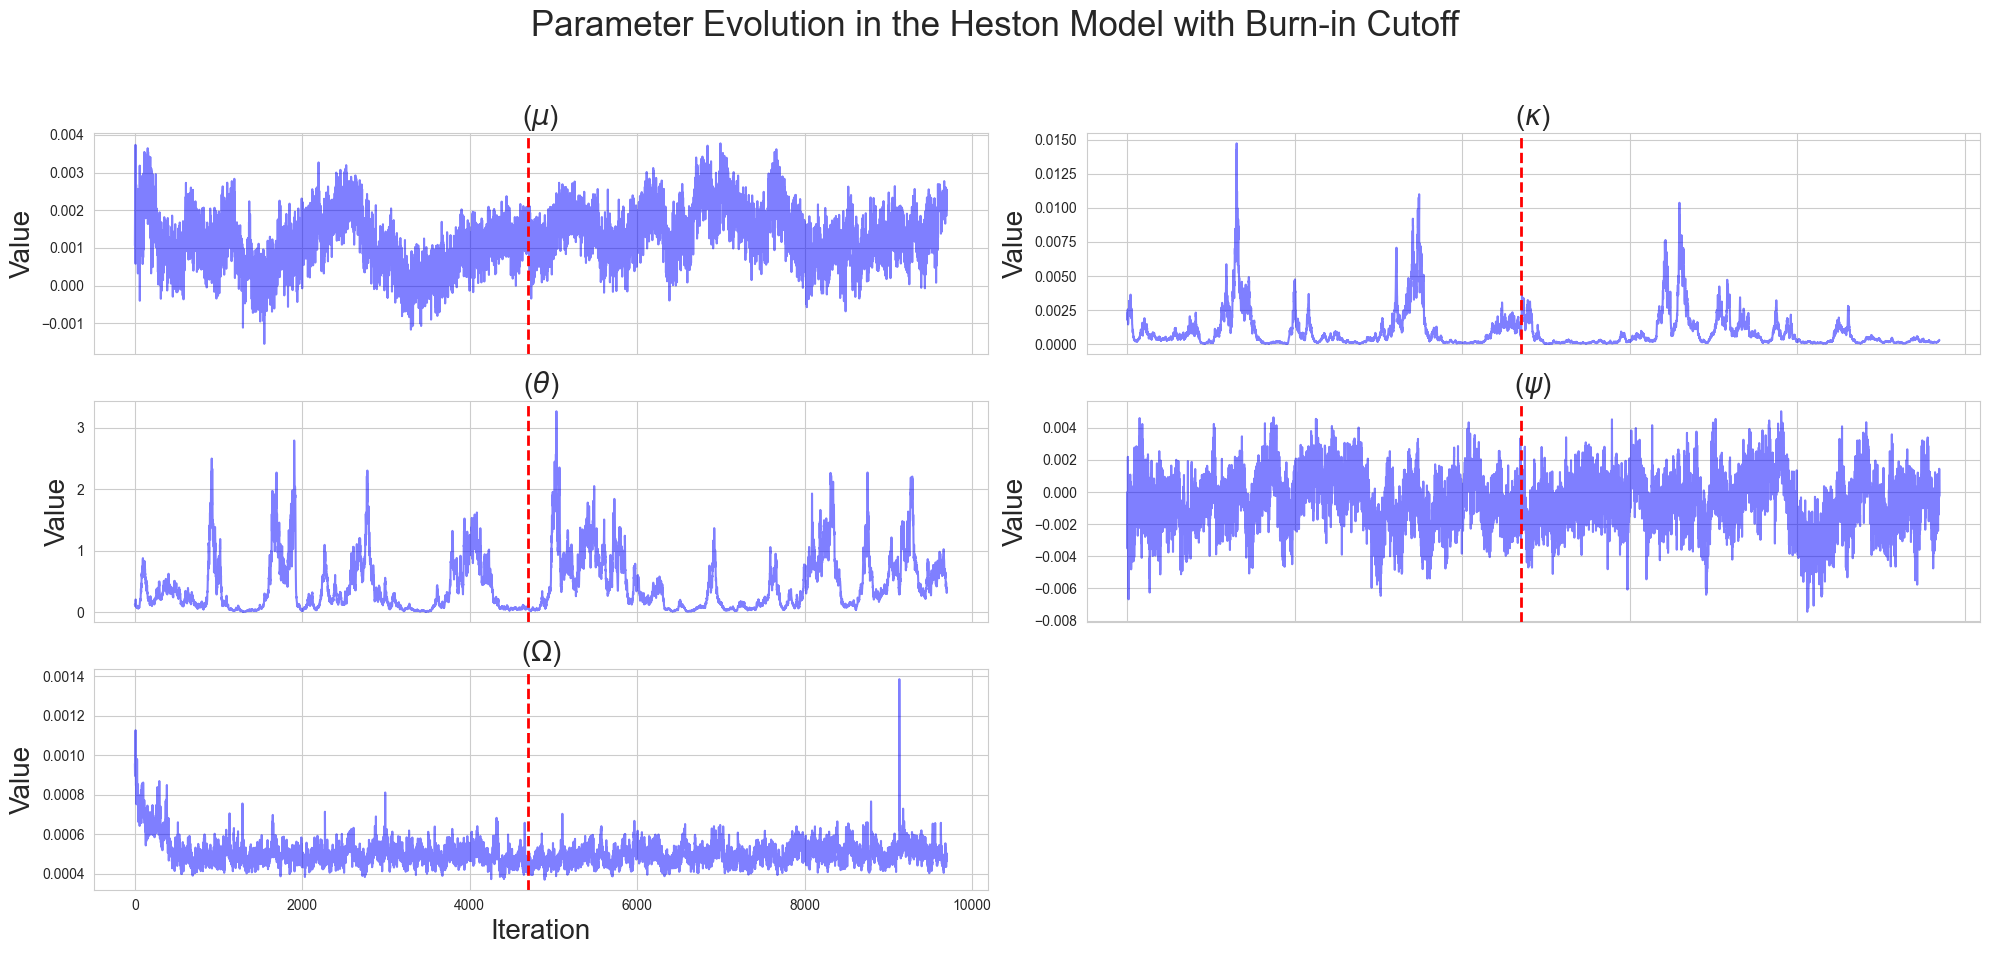

In [11]:
sns.set_style("whitegrid")

offset_from_start = 300  
burn_in_marker_position = burn_in - offset_from_start  
parameters_evolution = parameter_path[offset_from_start:, :]  

fig, axes = plt.subplots(3, 2, figsize=(20, 10), sharex=True) 

param_titles = ["($\\mu$)", "($\\kappa$)",
                "($\\theta$)", "($\\psi$)",
                "($\\Omega$)"]

for i, ax in enumerate(axes.flat[:-1]):
    sns.lineplot(ax=ax, data=parameters_evolution[:, i], color="blue", linewidth=1.5, alpha=0.5)
    ax.axvline(x=burn_in_marker_position, color="red", linestyle="--", linewidth=2)
    ax.set_title(param_titles[i], fontsize=20)
    ax.set_ylabel('Value', fontsize=20)
    ax.set_xlabel('Iteration', fontsize=20)

axes[-1, -1].remove()  

plt.suptitle('Parameter Evolution in the Heston Model with Burn-in Cutoff', fontsize=25)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


In [12]:
# Convert dictionaries to DataFrame
params_df = pd.DataFrame({
    'Parameter': ['mu', 'kappa', 'theta', 'volvol', 'rho'],
    'Mean': [parameter_result['mu_result'], parameter_result['kappa_result'], parameter_result['theta_result'], 
             parameter_result['volvol_result'], parameter_result['rho_result']],
    'Std Dev': [parameter_std['mu_std'], parameter_std['kappa_std'], parameter_std['theta_std'], 
                parameter_std['volvol_std'], parameter_std['rho_std']]
})

# Display the DataFrame
params_df

,Parameter,Mean,Std Dev
0,mu,0.001465,0.000668
1,kappa,0.000786,0.001153
2,theta,0.495983,0.462522
3,volvol,0.022337,0.007243
4,rho,-0.029971,0.241236


#### Plot of price and volatility paths: Simulate 2,000 days ahead

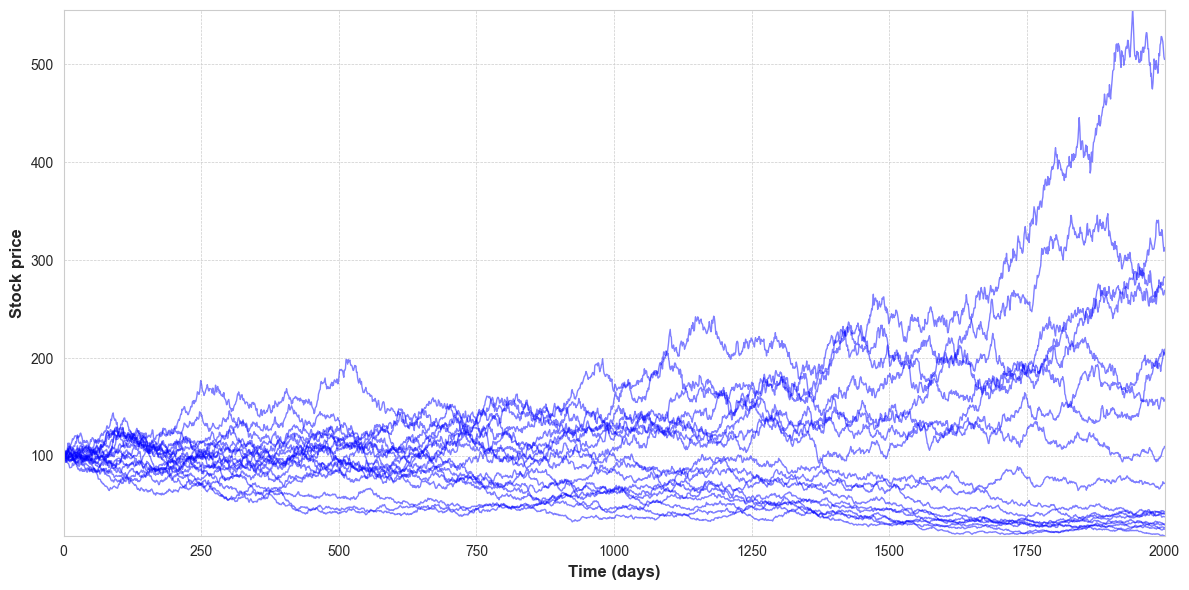

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
days = np.linspace(0, 1, nsteps + 1) * nsteps

prices = ax.plot(days, simulated_paths.transpose(), linewidth=1, alpha=0.5, color='blue')

# ax.set_title("Monte-Carlo Simulated Stock Price Paths in Heston Model", fontsize=14, fontweight='bold')
# subtitle_text = "$S_0$ = {}, $r-q$ = {}, $\\sigma$ = {}, $V_0$ = {}, $\\theta$ = {}, $\\kappa$ = {}, $\\rho$ = {}, Nsteps = {}, Nsim = {}".format(
#     *list(map(lambda x: round(x, 3), [s0, r - q, sigma, theta, theta, kappa, rho, nsteps, nsim])))
# ax.set_title(subtitle_text, fontsize=10, style='italic', pad=20)

ax.set_xlabel('Time (days)', fontsize=12, fontweight='bold')
ax.set_ylabel('Stock price', fontsize=12, fontweight='bold')

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

ax.set_xlim([days.min(), days.max()])
ax.set_ylim([simulated_paths.min(), simulated_paths.max()])

plt.tight_layout()
plt.show()


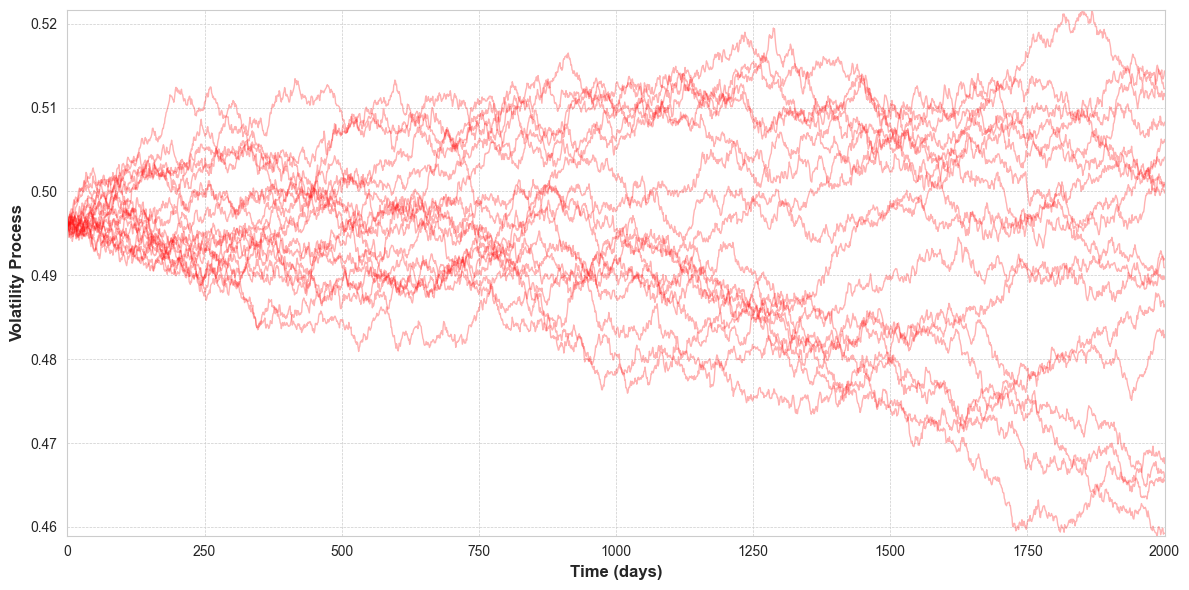

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
days = np.linspace(0, 1, nsteps + 1) * nsteps

bates_volas = ax.plot(days, simulated_variances.transpose(), linewidth=1, alpha=0.3, color='red')

# ax.set_title("Monte-Carlo Simulated Variance Paths in Heston Model", fontsize=14, fontweight='bold')
# subtitle_text = "$S_0$ = {}, $r$ = {}, $\\sigma$ = {}, $V_0$ = {}, $\\theta$ = {}, $\\kappa$ = {}, $\\rho$ = {}, Nsteps = {}, Nsim = {}".format(
#     *list(map(lambda x: round(x, 3), [s0, r, sigma, theta, theta, kappa, rho, nsteps, nsim])))
# ax.set_title(subtitle_text, fontsize=10, style='italic', pad=20)

ax.set_xlabel('Time (days)', fontsize=12, fontweight='bold')
ax.set_ylabel('Volatility Process', fontsize=12, fontweight='bold')

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

ax.set_xlim([days.min(), days.max()])
ax.set_ylim([simulated_variances.min(), simulated_variances.max()])

plt.tight_layout()
plt.show()

### Miscellaenous plots in the project

#### Section 2: Weiner Process

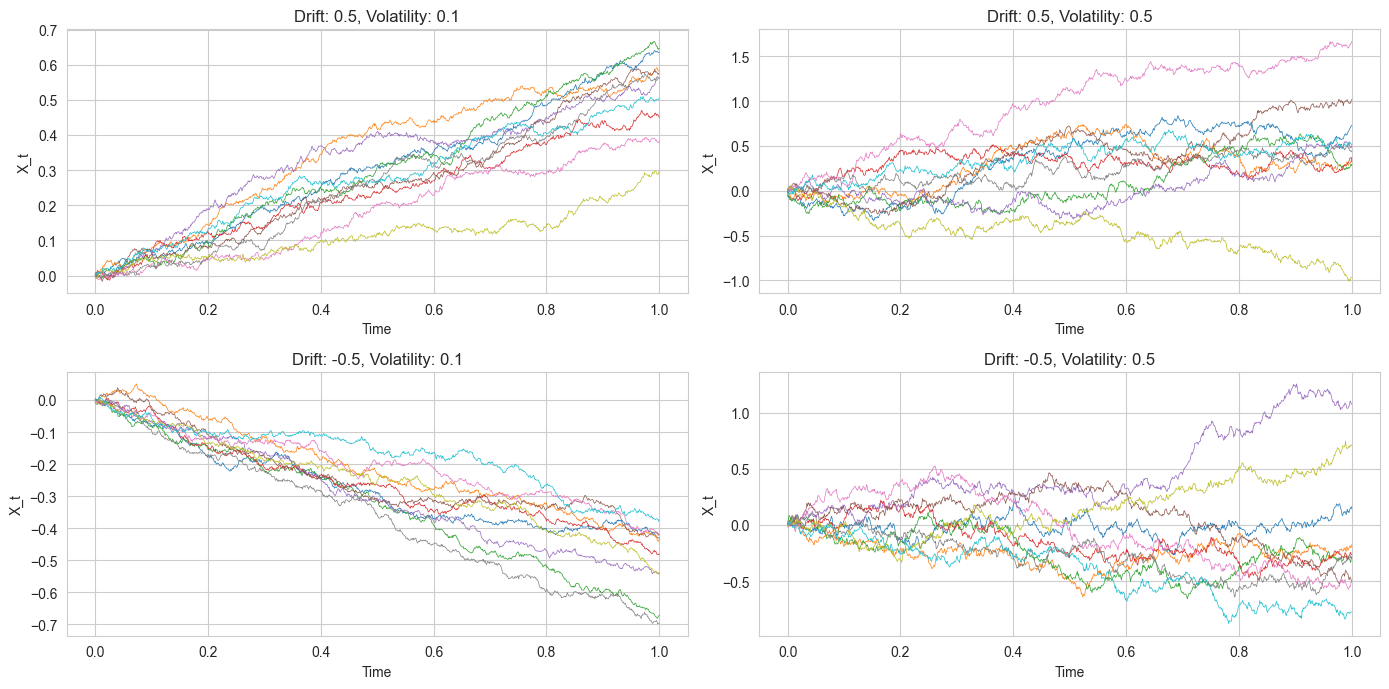

In [15]:
mu_values = [0.5, -0.5] # drift values
sigma_values = [0.1, 0.5] # volatility values
T = 1.0 # total time
N = 1000 # number of steps
dt = T/N # time step size
M = 10 # number of paths to simulate

t = np.linspace(0, T, N)

def generate_wiener_process(mu, sigma, dt, N, M):
    dW = np.random.normal(scale=np.sqrt(dt), size=(M, N)) 
    W = np.cumsum(dW, axis=1)
    drift = mu * t
    paths = drift + sigma * W
    return paths

plt.figure(figsize=(14, 7))

for i, mu in enumerate(mu_values):
    for j, sigma in enumerate(sigma_values):
        paths = generate_wiener_process(mu, sigma, dt, N, M)
        plt.subplot(len(mu_values), len(sigma_values), i*len(sigma_values)+j+1)
        for m in range(M):
            plt.plot(t, paths[m], lw=0.5)
        plt.title(f"Drift: {mu}, Volatility: {sigma}")
        plt.xlabel('Time')
        plt.ylabel('X_t')
        plt.grid(True)
plt.tight_layout()
plt.show()

#### Heston's model example

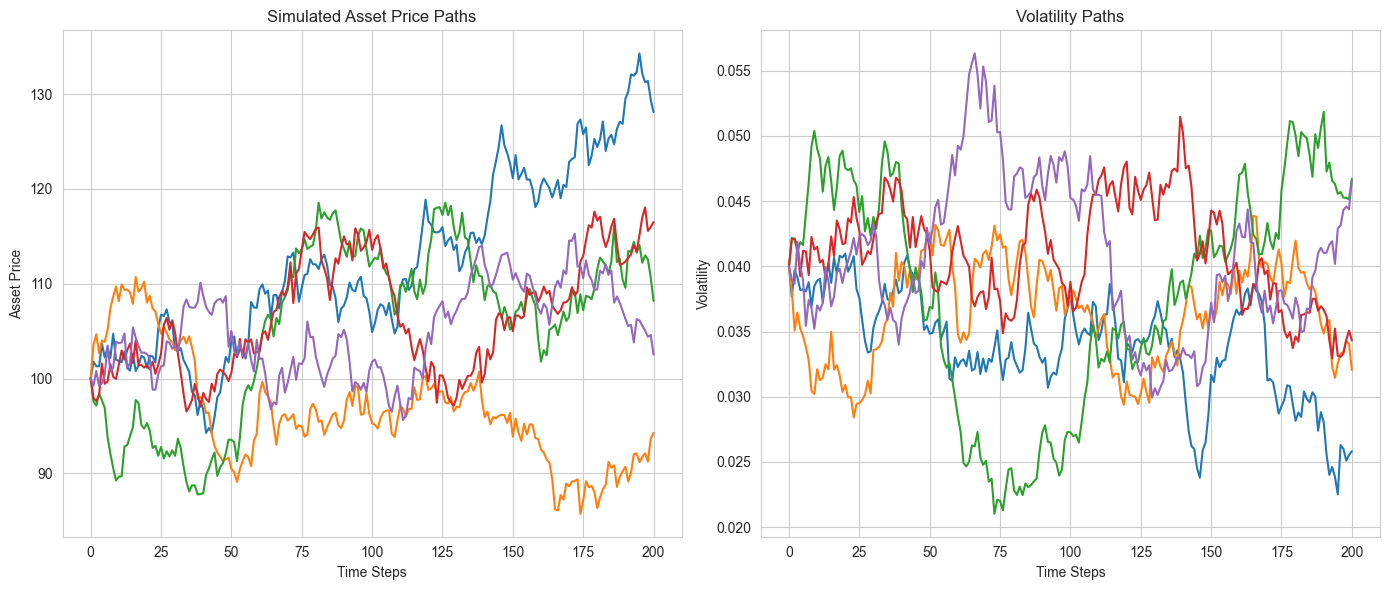

In [16]:
def simulate_heston_model(T, N, S0, V0, kappa, theta, sigma, rho, r, M):
    dt = T/N
    S = np.zeros((M, N+1))
    V = np.zeros((M, N+1))
    S[:, 0] = S0
    V[:, 0] = V0

    for t in range(1, N+1):
        z1 = np.random.normal(size=M)
        z2 = np.random.normal(size=M)
        z2 = rho*z1 + np.sqrt(1-rho**2)*z2  # correlated Wiener proces

        V[:, t] = np.maximum(V[:, t-1] + kappa*(theta-np.maximum(V[:, t-1], 0))*dt + sigma*np.sqrt(np.maximum(V[:, t-1], 0))*np.sqrt(dt)*z2, 0)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5*np.maximum(V[:, t-1], 0))*dt + np.sqrt(np.maximum(V[:, t-1], 0))*np.sqrt(dt)*z1)

    return S, V

T = 1  
N = 200  
S0 = 100  # initial stock price
V0 = 0.04  # initial volatility
kappa = 2  # rate of reversion
theta = 0.04  # long-term volatility mean
sigma = 0.1  # volatility of volatility
rho = -0.7  # correlation
r = 0.05 
M = 5  # number of paths

S, V = simulate_heston_model(T, N, S0, V0, kappa, theta, sigma, rho, r, M)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=S.T, dashes=False, legend=False, palette="tab10")
plt.title("Simulated Asset Price Paths")
plt.xlabel("Time Steps")
plt.ylabel("Asset Price")
plt.subplot(1, 2, 2)
sns.lineplot(data=V.T, dashes=False, legend=False, palette="tab10")
plt.title("Volatility Paths")
plt.xlabel("Time Steps")
plt.ylabel("Volatility")
plt.tight_layout()
plt.show()